### Import required libraries and necessary packages

In [30]:
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import argparse
import cv2
import os
import time


import keras
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.applications import VGG16
from keras.layers import AveragePooling2D, Dropout, Flatten, Dense, Input
from keras.models import Model, Sequential
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical


from sklearn.datasets import load_files
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import classification_report, confusion_matrix

In [31]:
#The path of our data on drive
data_dir = 'C:/Users/Meghana/Downloads/Project_work/COVID-19-Detection-From-X-Ray-master (2)/COVID-19-Detection-From-X-Ray-master/final_dataset'

 
#Loading Data
data = load_files(data_dir)

In [32]:
folders=os.listdir("C:/Users/Meghana/Downloads/Project_work/COVID-19-Detection-From-X-Ray-master (2)/COVID-19-Detection-From-X-Ray-master/final_dataset")
print(folders)

['COVID', 'non-COVID']


In [33]:
#Convert the data and labels to Numpy arrays
X = np.array(data['filenames'])
y = np.array(data['target'])
labels = np.array(data['target_names'])
 
# How the arrays look like?
print('Data files - ',X[0])
print('Target labels - ',y[0])
print('Number of training files : ', X.shape[0])
print('Number of training targets : ', y.shape[0])

Data files -  C:/Users/Meghana/Downloads/Project_work/COVID-19-Detection-From-X-Ray-master (2)/COVID-19-Detection-From-X-Ray-master/final_dataset\COVID\Covid (682).png
Target labels -  0
Number of training files :  2481
Number of training targets :  2481


### Convert images to arrays

In [34]:
def convert_img_to_arr(file_path_list):
    arr = []
    img_width, img_height = 224,224 
    #Loop over the image paths
    for file_path in file_path_list:
        """
           Load the image, swap color channels, and resize it to be a fixed
           224*224 pixels while ignoring aspect ratio
        """
        img = load_img(file_path, target_size = (img_width, img_height))
        img = img_to_array(img)
        
        #update the data
        arr.append(img)
    return arr
# Here our data is updated and it's stocked in the X array again !
X = np.array(convert_img_to_arr(X))

# The Data Shape
print(X.shape) 
print('First training item : ',X[0])

(2481, 224, 224, 3)
First training item :  [[[235. 235. 235.]
  [235. 235. 235.]
  [234. 234. 234.]
  ...
  [233. 233. 233.]
  [233. 233. 233.]
  [233. 233. 233.]]

 [[235. 235. 235.]
  [235. 235. 235.]
  [234. 234. 234.]
  ...
  [233. 233. 233.]
  [233. 233. 233.]
  [233. 233. 233.]]

 [[234. 234. 234.]
  [234. 234. 234.]
  [234. 234. 234.]
  ...
  [233. 233. 233.]
  [233. 233. 233.]
  [233. 233. 233.]]

 ...

 [[228. 228. 228.]
  [228. 228. 228.]
  [229. 229. 229.]
  ...
  [228. 228. 228.]
  [228. 228. 228.]
  [229. 229. 229.]]

 [[229. 229. 229.]
  [230. 230. 230.]
  [227. 227. 227.]
  ...
  [229. 229. 229.]
  [230. 230. 230.]
  [230. 230. 230.]]

 [[229. 229. 229.]
  [230. 230. 230.]
  [227. 227. 227.]
  ...
  [229. 229. 229.]
  [230. 230. 230.]
  [230. 230. 230.]]]


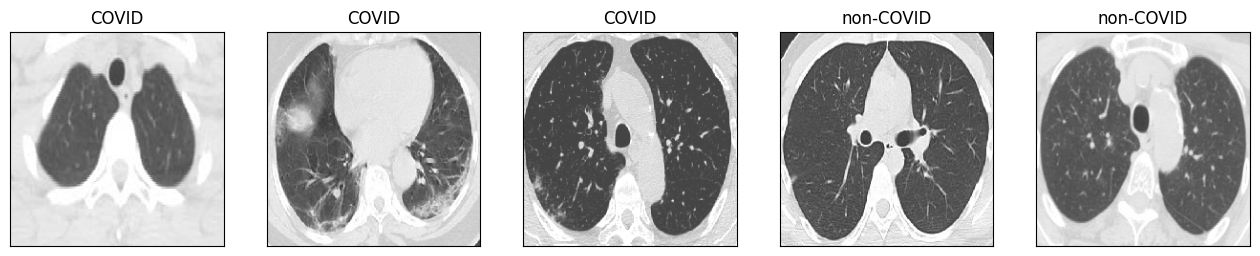

In [35]:
#Let's look at first 5 training data. 
fig = plt.figure(figsize = (16,9))
for i in range(5):
    ax = fig.add_subplot(1,5,i+1,xticks=[],yticks=[])
    ax.imshow((X[i].astype(np.uint8)))
    plt.title(folders[y[i]])

> **rescale value** is a value by which we will multiply the data before any other processing. Our original images consist in RGB coefficients in the 0-255, but such values would be too high for our models to process (given a typical learning rate), so we target values between 0 and 1 instead by scaling with a 1/255. factor. So all values in X will lie within 0 to 1 !

In [36]:
"""
   After that data is converted into Numpy array, Now, 
   Let's scale the pixel intenties to the range[0,255]
"""
X = X.astype('float32')/255

# Let's confirm the number of classes :) 
no_of_classes = len(np.unique(y))
no_of_classes

2

In [37]:
y

array([0, 0, 0, ..., 0, 0, 1])

 ### Let's converts a class vector (integers) to binary class matrix

In [38]:
import numpy as np
from tensorflow.keras.utils import to_categorical

y = np.array(to_categorical(y,no_of_classes))
y[0]

array([1., 0.])

In [50]:
# let's splite the data into subsets and explore their shapes !

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2)
print('The train Data Shape ', X_train.shape[0])
 
X_test, X_valid, y_test, y_valid = train_test_split(X_test,y_test, test_size = 0.5)
print('The validation Data Shape ', X_valid.shape[0])
print('The test Data Shape ', X_test.shape[0])

The train Data Shape  1984
The validation Data Shape  249
The test Data Shape  248


In [51]:
print('The train Data Shape ', X_train.shape[1:])

The train Data Shape  (224, 224, 3)


> **(224, 224, 3)** refers to the shape of the data (images) that will be fed into our CNN

---

In [52]:
from keras.applications import ResNet50
from keras.layers import BatchNormalization

In [53]:
model = Sequential()

model.add(ResNet50(include_top=False, pooling='avg', weights='imagenet'))
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(2048, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(1024, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(no_of_classes, activation='softmax'))

model.layers[0].trainable = False

In [54]:
#I can check the summary of the final Model which we created by using the line of code below.
model.summary()

ValueError: Undefined shapes are not supported.

In [56]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import ExponentialDecay

# Define learning rate schedule
initial_learning_rate = 0.001
lr_schedule = ExponentialDecay(
    initial_learning_rate=initial_learning_rate,
    decay_steps=1000,
    decay_rate=0.96,
    staircase=True
)

# Initialize Adam optimizer with learning rate schedule
optimizer = Adam(learning_rate=lr_schedule)

# Compile the model
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])


---

In [61]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint
import time

# Number of epochs
epochs = 100
batch_size = 8  # Ensure this is set correctly

# Initialize the training data augmentation object
train_datagen = ImageDataGenerator(
    rotation_range=15,
    fill_mode="nearest"
)

# Initialize the checkpoint callback with the updated filepath extension
checkpointer = ModelCheckpoint(filepath="/gdrive/My Drive/CDX_Best_RestNet50.keras", save_best_only=True, verbose=1)

# Start time
start = time.time()

# Train the model
history = model.fit(
    train_datagen.flow(X_train, y_train, batch_size=batch_size),
    steps_per_epoch=len(X_train) // batch_size,
    validation_data=(X_valid, y_valid),
    validation_steps=len(X_valid) // batch_size,
    epochs=epochs,
    callbacks=[checkpointer]
)

# End time
end = time.time()
duration = end - start

# Print training duration
print(f'\n This Model took {duration:0.2f} seconds ({duration/60:0.1f} minutes) to train for {epochs} epochs')


Epoch 1/100


c:\Users\Meghana\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


248/248 ━━━━━━━━━━━━━━━━━━━━ 0s 424ms/step - accuracy: 0.6510 - loss: 0.9769
Epoch 1: val_loss improved from inf to 0.59563, saving model to /gdrive/My Drive/CDX_Best_RestNet50.keras


c:\Users\Meghana\AppData\Local\Programs\Python\Python311\Lib\contextlib.py:155: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


248/248 ━━━━━━━━━━━━━━━━━━━━ 133s 489ms/step - accuracy: 0.6512 - loss: 0.9758 - val_accuracy: 0.6345 - val_loss: 0.5956
Epoch 2/100

Epoch 2: val_loss did not improve from 0.59563
248/248 ━━━━━━━━━━━━━━━━━━━━ 11s 43ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.6345 - val_loss: 0.5956
Epoch 3/100
248/248 ━━━━━━━━━━━━━━━━━━━━ 0s 454ms/step - accuracy: 0.7405 - loss: 0.5649
Epoch 3: val_loss improved from 0.59563 to 0.41246, saving model to /gdrive/My Drive/CDX_Best_RestNet50.keras
248/248 ━━━━━━━━━━━━━━━━━━━━ 127s 511ms/step - accuracy: 0.7406 - loss: 0.5648 - val_accuracy: 0.8353 - val_loss: 0.4125
Epoch 4/100

Epoch 4: val_loss did not improve from 0.41246
248/248 ━━━━━━━━━━━━━━━━━━━━ 13s 51ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.8353 - val_loss: 0.4125
Epoch 5/100
248/248 ━━━━━━━━━━━━━━━━━━━━ 0s 541ms/step - accuracy: 0.7784 - loss: 0.4752
Epoch 5: val_loss did not improve from 0.41246
248/248 ━━━━━━━━━━━━━━━━━━━━ 153s 614ms/step - ac

**==> After training the model, we will be able to see the spectacular and the impressive performance reached ! :)**

---

### **Evaluation**
> The result of the script below shows the accuracy and loss of the test, using test data of course !

In [62]:
(eval_loss, eval_accuracy) = model.evaluate(  
     X_test, y_test, batch_size=bs, verbose=2)
 
print("Accuracy: {:.2f}%".format(eval_accuracy * 100)) 
print("Loss: {}".format(eval_loss))

31/31 - 11s - 370ms/step - accuracy: 0.9234 - loss: 0.1740
Accuracy: 92.34%
Loss: 0.17395059764385223


### Accuracy and Loss graphs

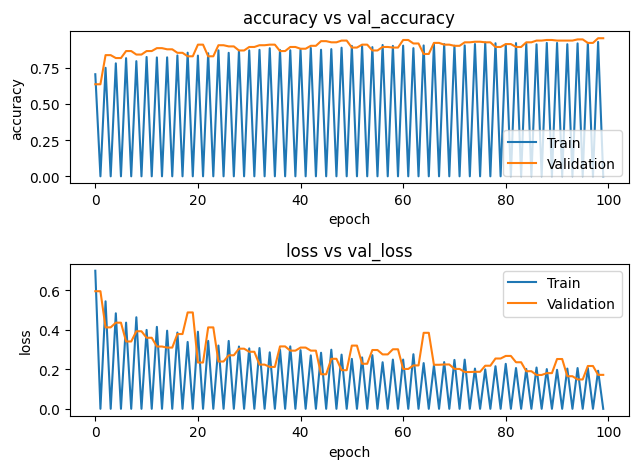

In [63]:
# Let's visualize the train/validation loss and accuracy wrt epochs

import matplotlib.pyplot as plt 
def plot(history):
    plt.figure(1) 
     # summarize history for accuracy  
 
    plt.subplot(211)  
    plt.plot(history.history['accuracy'])  
    plt.plot(history.history['val_accuracy'])  
    plt.title('accuracy vs val_accuracy')  
    plt.ylabel('accuracy')  
    plt.xlabel('epoch')  
    plt.legend(['Train', 'Validation'], loc='lower right')  
 
     # summarize history for loss  
 
    plt.subplot(212)  
    plt.plot(history.history['loss'])  
    plt.plot(history.history['val_loss'])  
    plt.title('loss vs val_loss')  
    plt.ylabel('loss')  
    plt.xlabel('epoch')  
    plt.legend(['Train', 'Validation'], loc='upper right')
    plt.tight_layout()
    plt.show()
 
# Finaly, let's call the plot function with the 'result' parameter 
 
plot(history)

### **Prediction**
>Finally, let us test our model against more random samples from the test data !

8/8 ━━━━━━━━━━━━━━━━━━━━ 16s 2s/step


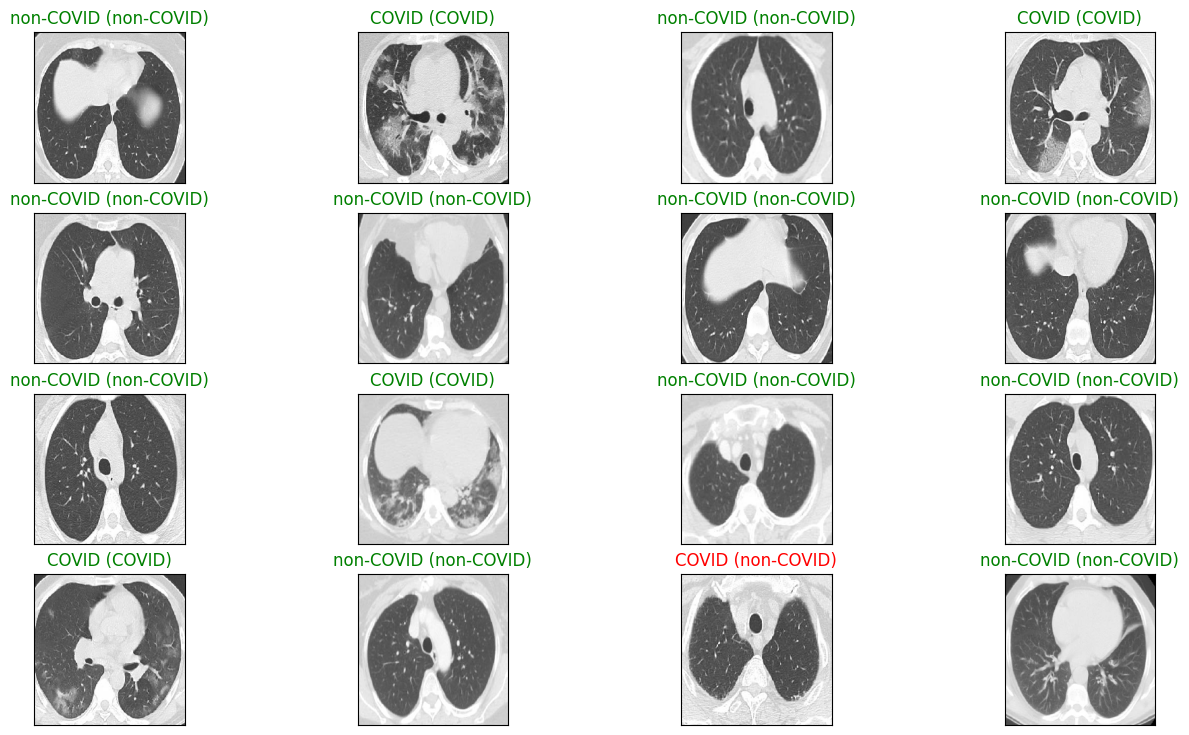

In [64]:
# Let's visualize some random test prediction.
def visualize_pred(y_pred):
# plot a random sample of test images, their predicted labels, and ground truth
    fig = plt.figure(figsize=(16, 9))
    for i, idx in enumerate(np.random.choice(X_test.shape[0], size=16, replace=False)):
        ax = fig.add_subplot(4, 4, i + 1, xticks=[], yticks=[])
        ax.imshow(np.squeeze(X_test[idx]))
        pred_idx = np.argmax(y_pred[idx])
        true_idx = np.argmax(y_test[idx])
        ax.set_title("{} ({})".format(labels[pred_idx], labels[true_idx]),
                     color=("green" if pred_idx == true_idx else "red"))

visualize_pred(model.predict(X_test))

8/8 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step


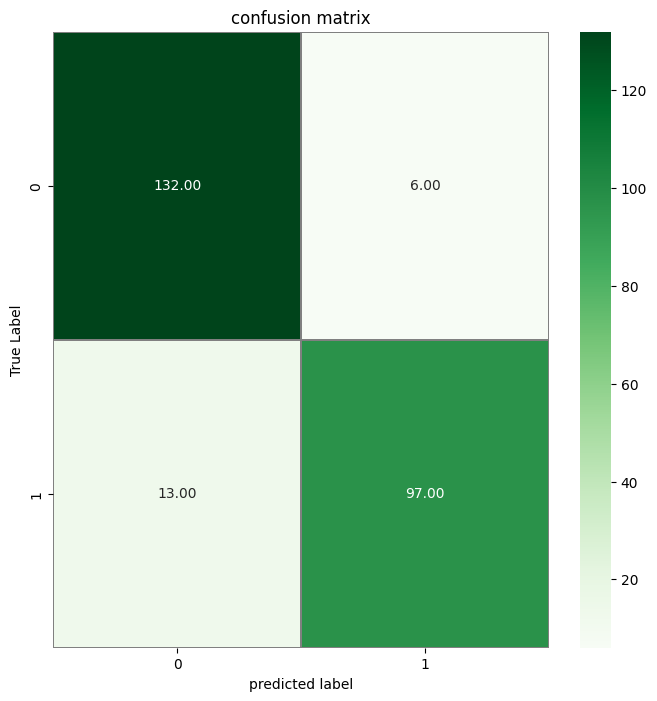

In [65]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

Y_pred = model.predict(X_test)
Y_pred_classes = np.argmax(Y_pred,axis = 1)
Y_true = np.argmax(y_test,axis = 1)
confusion_mtx = confusion_matrix(Y_true,Y_pred_classes)
f,ax = plt.subplots(figsize = (8,8))
sns.heatmap(confusion_mtx,annot=True,linewidths = 0.01,cmap="Greens",
            linecolor = "gray",fmt = ".2f",ax=ax
            )
plt.xlabel("predicted label")
plt.ylabel("True Label")
plt.title("confusion matrix")
plt.show()

In [66]:
print(classification_report(y_test.argmax(axis=1),Y_pred_classes,  target_names= labels))

              precision    recall  f1-score   support

       COVID       0.91      0.96      0.93       138
   non-COVID       0.94      0.88      0.91       110

    accuracy                           0.92       248
   macro avg       0.93      0.92      0.92       248
weighted avg       0.92      0.92      0.92       248



8/8 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step


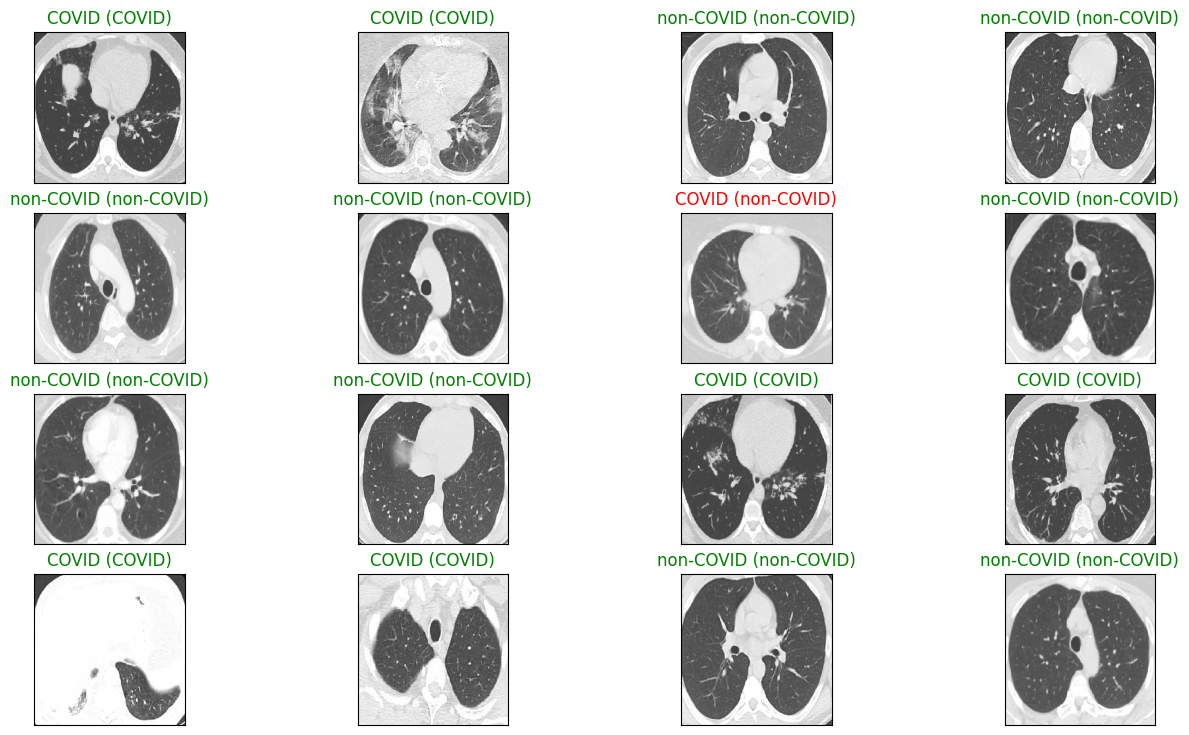

In [69]:
# Let's visualize some random test prediction.
def visualize_pred(y_pred):
# plot a random sample of test images, their predicted labels, and ground truth
    fig = plt.figure(figsize=(16, 9))
    for i, idx in enumerate(np.random.choice(X_test.shape[0], size=16, replace=False)):
        ax = fig.add_subplot(4, 4, i + 1, xticks=[], yticks=[])
        ax.imshow(np.squeeze(X_test[idx]))
        pred_idx = np.argmax(y_pred[idx])
        true_idx = np.argmax(y_test[idx])
        ax.set_title("{} ({})".format(labels[pred_idx], labels[true_idx]),
                     color=("green" if pred_idx == true_idx else "red"))

visualize_pred(model.predict(X_test))